In [1]:
from biofuzznet.utils import read_sif
from biofuzznet.biofuzznet import BioFuzzNet
import networkx as nx
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cl_data = pd.read_csv("/Users/adr/Box/CAR_Tcells/Data/DREAMdata/ZR7530.csv")
non_marker_cols = ["treatment", "cell_line", "time", "cellID", "fileID"]
markers = [c for c in cl_data.columns if not c in non_marker_cols]

cl_data = cl_data[cl_data["time"]==9]
scaler = MinMaxScaler()
cl_data[markers] = scaler.fit_transform(cl_data[markers])

In [3]:
cl_data

,treatment,cell_line,time,cellID,fileID,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,...,p.PDPK1,p.PLCg2,p.RB,p.S6,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,p.STAT5
25595,EGF,ZR7530,9.0,1,1011,0.395636,0.402194,0.000000,0.492295,0.104349,...,0.375356,0.352125,0.099567,0.273289,0.369775,0.186604,0.383592,0.328056,0.441879,0.340322
25596,EGF,ZR7530,9.0,2,1011,0.000000,0.140044,0.537944,0.409615,0.897755,...,0.000000,0.082241,0.598982,0.378096,0.109032,0.478256,0.245605,0.355943,0.169588,0.300694
25597,EGF,ZR7530,9.0,3,1011,0.279084,0.432673,0.000000,0.713174,0.253652,...,0.210846,0.104309,0.303606,0.395779,0.563735,0.486540,0.255902,0.368843,0.457316,0.304705
25598,EGF,ZR7530,9.0,4,1011,0.000000,0.267420,0.141758,0.430330,0.000000,...,0.020738,0.449832,0.000000,0.453254,0.726091,0.000000,0.398669,0.446374,0.232850,0.345303
25599,EGF,ZR7530,9.0,5,1011,0.530664,0.402922,0.262447,0.677272,0.679108,...,0.590596,0.658284,0.828589,0.609928,0.596778,0.634626,0.410794,0.434798,0.531388,0.382133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438604,iPKC,ZR7530,9.0,8364,981,0.605812,0.292460,0.141792,0.563163,0.029755,...,0.436423,0.599954,0.152836,0.384682,0.554484,0.375520,0.454312,0.329122,0.651206,0.379009
438605,iPKC,ZR7530,9.0,8365,981,0.000000,0.000000,0.131784,0.369437,0.158079,...,0.000000,0.287432,0.000000,0.353103,0.277070,0.445072,0.132246,0.303992,0.311794,0.383396
438606,iPKC,ZR7530,9.0,8366,981,0.584230,0.312458,0.727297,0.552922,0.429372,...,0.501491,0.559899,0.748482,0.391360,0.604408,0.340593,0.354785,0.456384,0.446863,0.387726
438607,iPKC,ZR7530,9.0,8367,981,0.125551,0.480262,0.115179,0.736958,0.172115,...,0.422837,0.738014,0.231625,0.356163,0.653604,0.737798,0.315952,0.361219,0.413430,0.336527


In [4]:
nodes1, edges1 = read_sif("/Users/adr/Box/CAR_Tcells/Data/DREAMdata/prior_knowledge.sif")

In [5]:
nodes, edges = read_sif("/Users/adr/Box/CAR_Tcells/Data/DREAMdata/DREAM_PKN_for_BFZ_input.sif")
edges[("JNK", "p53")] = 1
sel_nodes = ["MKK4", "JNK", "p53", "RB"]

sel_edges = {k: v for k,v in edges.items() if (k[1] in sel_nodes) and (k[0] in sel_nodes)}
sel_edges

{('p53', 'RB'): '1', ('MKK4', 'JNK'): '1', ('JNK', 'p53'): 1}

In [6]:
G=nx.from_edgelist(sel_edges)

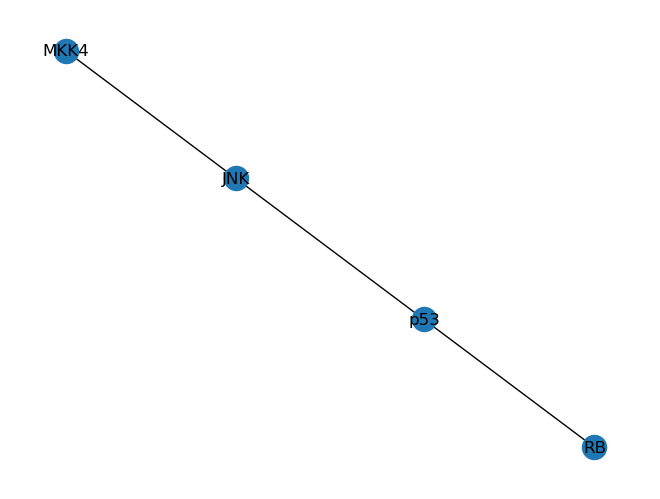

In [7]:
nx.draw(G, with_labels=True)

In [8]:
# Create an empty BioFuzzNet
my_model = BioFuzzNet(None, None)

# Add nodes
# my_model.add_fuzzy_node("input", "BIO")
my_model.add_fuzzy_node("p.MKK4", "BIO") # A biological node
my_model.add_fuzzy_node("p.JNK", 'BIO')
my_model.add_fuzzy_node("p.p53", "BIO")
my_model.add_fuzzy_node("p.RB", "BIO")
# Add edges
# my_model.add_transfer_edge("input","p.MKK4")
my_model.add_transfer_edge("p.MKK4","p.JNK") 
my_model.add_transfer_edge("p.JNK", "p.p53")
my_model.add_transfer_edge("p.p53", "p.RB")

In [9]:
my_model.root_nodes

['p.MKK4']

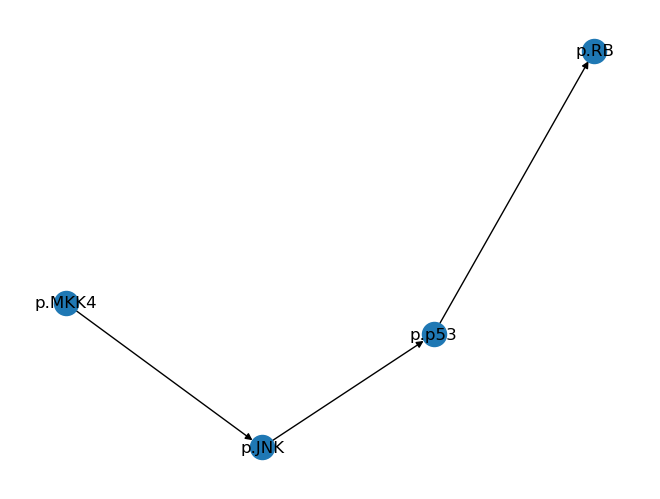

In [10]:
nx.draw(my_model, with_labels=True)

In [11]:
sel_data = cl_data.loc[(cl_data["treatment"]=="EGF"),:][["p.p53", "p.MKK4", "p.JNK", "p.RB"]]
sel_data.reset_index(drop=True, inplace=True)
sel_data

,p.p53,p.MKK4,p.JNK,p.RB
0,0.194365,0.457823,0.426876,0.099567
1,0.000000,0.400166,0.288711,0.598982
2,0.224935,0.577745,0.492829,0.303606
3,0.211484,0.545781,0.355599,0.000000
4,0.238072,0.779333,0.650283,0.828589
...,...,...,...,...
16375,0.203940,0.366302,0.225716,0.080011
16376,0.181002,0.557901,0.333460,0.161690
16377,0.021770,0.480255,0.000000,0.308577
16378,0.166905,0.465469,0.395624,0.155100


In [12]:
train, test = train_test_split(sel_data)
print(train.shape)
print(test.shape)
train = train.to_dict("list")
test = test.to_dict("list")

train = {k: torch.DoubleTensor(v) for k, v in train.items()}
test = {k: torch.DoubleTensor(v) for k, v in test.items()}

input_train = {"p.MKK4" : train["p.MKK4"]}
input_test = {"p.MKK4": test["p.MKK4"]}


(12285, 4)
(4095, 4)


In [13]:
print(input_train["p.MKK4"].shape)
input_train

torch.Size([12285])


{'p.MKK4': tensor([0.4695, 0.4646, 0.4113,  ..., 0.1825, 0.1901, 0.6987])}

In [14]:
print(train["p.MKK4"].shape)
train

torch.Size([12285])


{'p.p53': tensor([0.1001, 0.2479, 0.1604,  ..., 0.1853, 0.0833, 0.2498]),
 'p.MKK4': tensor([0.4695, 0.4646, 0.4113,  ..., 0.1825, 0.1901, 0.6987]),
 'p.JNK': tensor([0.2803, 0.4159, 0.2764,  ..., 0.2579, 0.0317, 0.2411]),
 'p.RB': tensor([0.0292, 0.4907, 0.0366,  ..., 0.6372, 0.5154, 0.3099])}

In [15]:
# Now we just need to specify some optimisation parameters

learning_rate = 5e-3
epochs = 2 # That seems like a lot, but 1 epoch is basically one simulation of the network on all datapoints, so we need a lot of them
batch_size = 300 

In [16]:
loss = my_model.conduct_optimisation(input = input_train,
                                     test_input = input_test,
                                     ground_truth=train,
                                     epochs = epochs, 
                                     test_ground_truth=test,
                                     learning_rate= learning_rate,
                                     batch_size= batch_size
                                         )

  0%|                                                                       | 0/2 [00:00<?, ?it/s]/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: Error detected in PowBackward1. Traceback of forward call that caused the error:
  File "/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
    self.io

tensor(0.0493, grad_fn=<MeanBackward0>)
tensor(0.0481, grad_fn=<MeanBackward0>)


RuntimeError: Function 'PowBackward1' returned nan values in its 0th output.

In [ ]:
loss

In [ ]:
sns.lineplot(data=loss, x='time', y='loss', hue='phase')

# Leave a treatment out

In [17]:
all_treatments = ['EGF', 'full', 'iEGFR', 'iMEK', 'iPI3K', 'iPKC']
test_treatments = ['iEGFR']
train_treatments = [treatment for treatment in all_treatments if not treatment in test_treatments]

train = cl_data.loc[(cl_data["treatment"].isin(train_treatments)), ["p.p53", "p.MKK4", "p.JNK", "p.RB"]]
test = cl_data.loc[(cl_data["treatment"].isin(test_treatments)), ["p.p53", "p.MKK4", "p.JNK", "p.RB"]]
n_test = len(test)

print(train.shape)
print(test.shape)
train = train.to_dict("list")
test = test.to_dict("list")

train = {k: torch.DoubleTensor(v) for k, v in train.items()}
test = {k: torch.DoubleTensor(v) for k, v in test.items()}

input_train = {"p.MKK4" : train["p.MKK4"]}
input_test = {"p.MKK4": test["p.MKK4"]}

(44516, 4)
(13435, 4)


In [18]:
# Create an empty BioFuzzNet
my_model = BioFuzzNet(None, None)

# Add nodes
# my_model.add_fuzzy_node("input", "BIO")
my_model.add_fuzzy_node("p.MKK4", "BIO") # A biological node
my_model.add_fuzzy_node("p.JNK", 'BIO')
my_model.add_fuzzy_node("p.p53", "BIO")
my_model.add_fuzzy_node("p.RB", "BIO")
# Add edges
# my_model.add_transfer_edge("input","p.MKK4")
my_model.add_transfer_edge("p.MKK4","p.JNK") 
my_model.add_transfer_edge("p.JNK", "p.p53")
my_model.add_transfer_edge("p.p53", "p.RB")

In [19]:
# Now we just need to specify some optimisation parameters

learning_rate = 5e-3
epochs = 1 # That seems like a lot, but 1 epoch is basically one simulation of the network on all datapoints, so we need a lot of them
batch_size = 300 

In [20]:
loss = my_model.conduct_optimisation(input = input_train,
                                     test_input = input_test,
                                     ground_truth=train,
                                     epochs = epochs, 
                                     test_ground_truth=test,
                                     learning_rate= learning_rate,
                                     batch_size= batch_size
                                         )

  0%|                                                                       | 0/1 [00:00<?, ?it/s]/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: Error detected in PowBackward1. Traceback of forward call that caused the error:
  File "/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
    self.io

tensor(0.0868, grad_fn=<MeanBackward0>)
tensor(0.0860, grad_fn=<MeanBackward0>)


RuntimeError: Function 'PowBackward1' returned nan values in its 0th output.

In [21]:
# Create an empty BioFuzzNet
random_model = BioFuzzNet(None, None)

# Add nodes
# my_model.add_fuzzy_node("input", "BIO")
random_model.add_fuzzy_node("p.MKK4", "BIO") # A biological node
random_model.add_fuzzy_node("p.JNK", 'BIO')
random_model.add_fuzzy_node("p.p53", "BIO")
random_model.add_fuzzy_node("p.RB", "BIO")
# Add edges
# my_model.add_transfer_edge("input","p.MKK4")
random_model.add_transfer_edge("p.MKK4","p.JNK") 
random_model.add_transfer_edge("p.JNK", "p.p53")
random_model.add_transfer_edge("p.p53", "p.RB")

random_model.initialise_random_truth_and_output(n_test)

random_pred = random_model.output_states
random_pred["p.MKK4"] = test["p.MKK4"]

loss_func = torch.nn.MSELoss()
MSE = sum([loss_func(test[node], random_pred[node]).item() for node in my_model.nodes]) / len(my_model.nodes)
print(MSE)

0.13400975483553598


In [ ]:
sns.lineplot(data=loss, x='time', y='loss', hue='phase')
plt.axhline(y=MSE, color="red", linestyle = "--")

In [ ]:
random_model.output_states["p.MKK4"].size()

In [ ]:
my_model.nodes

# Different linear cascade

In [22]:
sel_data = cl_data.loc[(cl_data["treatment"]=="EGF"),:][['p.MEK', 'p.ERK', 'p.p90RSK', 'p.CREB']]
sel_data.reset_index(drop=True, inplace=True)
# sel_data["input"] = 1.
sel_data

,p.MEK,p.ERK,p.p90RSK,p.CREB
0,0.367667,0.330656,0.572618,2.961296e-01
1,0.463700,0.241769,0.529345,1.611169e-07
2,0.394335,0.388390,0.513064,2.144081e-01
3,0.442553,0.407983,0.839117,2.696125e-01
4,0.491981,0.438286,0.831320,3.145570e-01
...,...,...,...,...
16375,0.383218,0.312925,0.404499,1.611169e-07
16376,0.380585,0.374604,0.634937,3.070390e-01
16377,0.229955,0.264660,0.385332,2.470109e-01
16378,0.390229,0.315155,0.505230,3.154158e-01


In [23]:
# Check for NaNs in the input data
sel_data.isna().sum().sum()

0

In [24]:
train, test = train_test_split(sel_data)
print(train.shape)
print(test.shape)
train = train.to_dict("list")
test = test.to_dict("list")

train = {k: torch.DoubleTensor(v) for k, v in train.items()}
test = {k: torch.DoubleTensor(v) for k, v in test.items()}

input_train = {"p.MEK": train["p.MEK"]} # 
input_test = {"p.MEK": test["p.MEK"]} # 


(12285, 4)
(4095, 4)


In [25]:
# Create an empty BioFuzzNet
my_model = BioFuzzNet(None, None)

# Add nodes
# my_model.add_fuzzy_node("input", "BIO")
my_model.add_fuzzy_node("p.MEK", "BIO") # A biological node
my_model.add_fuzzy_node("p.ERK", 'BIO')
my_model.add_fuzzy_node("p.p90RSK", "BIO")
my_model.add_fuzzy_node("p.CREB", "BIO")
# Add edges
# my_model.add_transfer_edge("input","p.MEK")
my_model.add_transfer_edge("p.MEK","p.ERK") 
my_model.add_transfer_edge("p.ERK", "p.p90RSK")
my_model.add_transfer_edge("p.p90RSK", "p.CREB")

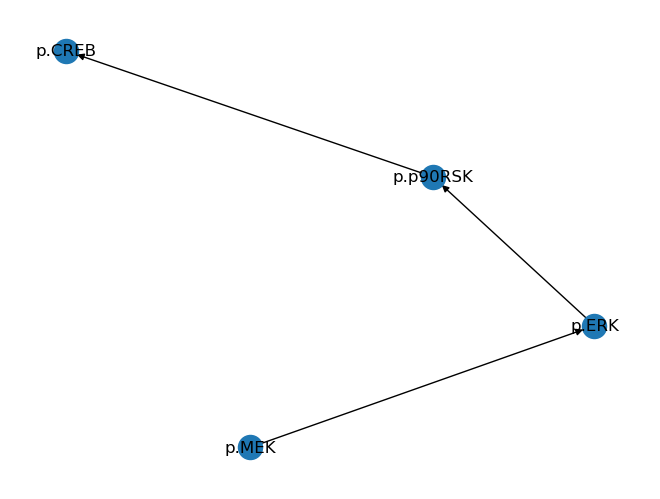

In [26]:
nx.draw(my_model, with_labels=True)

In [27]:
# Now we just need to specify some optimisation parameters

learning_rate = 5e-3
epochs = 20 # That seems like a lot, but 1 epoch is basically one simulation of the network on all datapoints, so we need a lot of them
batch_size = 300 

In [28]:
loss = my_model.conduct_optimisation(input = input_train,
                                     test_input = input_test,
                                     ground_truth=train,
                                     epochs = epochs, 
                                     test_ground_truth=test,
                                     learning_rate= learning_rate,
                                     batch_size= batch_size
                                         )

  0%|                                                                      | 0/20 [00:00<?, ?it/s]/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: Error detected in PowBackward1. Traceback of forward call that caused the error:
  File "/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
    self.io

tensor(0.0198, grad_fn=<MeanBackward0>)


RuntimeError: Function 'PowBackward1' returned nan values in its 0th output.

In [29]:
sns.lineplot(data=loss, x='time', y='loss', hue='phase')


NameError: name 'loss' is not defined